In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import sys
import pathlib
import pickle
import warnings

sys.path.append('..')

In [4]:
import pandas as pd
from loguru import logger
import seaborn as sns

In [5]:
from pals.pimp_tools import get_pimp_API_token_from_env, PIMP_HOST, download_from_pimp
from pals.noise import construct_intensity_df, add_random_peaks, plot_intensity_matrix, convert_to_data_source
from pals.evaluation import run_noise_experiment, calc_av_p_scores, construct_single_box_df, _compute_prec_rec_f1, _select_significant_entries, get_tp_fn_fn, adjust_box_widths, get_auc_for_noise
from pals.feature_extraction import DataSource

from pals.PALS import PALS
from pals.ORA import ORA
from pals.GSEA import GSEA
from pals.common import *

2020-03-06 14:10:19.913 | WARNING  | pals.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2020-03-06 14:10:19.913 | WARNING  | pals.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2020-03-06 14:10:20.977 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


## Synthetic data test

In [6]:
control_fnames = ['Control_1.mzXML', 'Control_2.mzXML', 'Control_3.mzXML', 'Control_4.mzXML']
case_fnames = ['Case_1.mzXML', 'Case_2.mzXML', 'Case_3.mzXML', 'Case_4.mzXML']
pathway_names ={'two':2, 'four':4, 'six':6, 'ten':10, 'twenty':20, 'forty':40, 'eighty':80}
sample_fnames = control_fnames + case_fnames
true_answers = set(pathway_names.keys())

num_iterations = 500
bg_pw = 100
gsea_resamples = 1000
gsea_ranking_method = GSEA_RANKING_SNR
min_replace = 5000
plage_weight = 1
hg_weight = 0
prob_missing_peaks = 0.2
parallel = True

base_dir = os.path.join('test_data', 'synthetic')
create_if_not_exist(base_dir)

Try generating some synthetic data without noise

(2966, 8)
{'two': 2, 'four': 4, 'six': 6, 'ten': 10, 'twenty': 20, 'forty': 40, 'eighty': 80, 'background0': 33, 'background1': 9, 'background2': 22, 'background3': 31, 'background4': 20, 'background5': 21, 'background6': 34, 'background7': 39, 'background8': 34, 'background9': 6, 'background10': 19, 'background11': 14, 'background12': 23, 'background13': 14, 'background14': 35, 'background15': 21, 'background16': 42, 'background17': 45, 'background18': 17, 'background19': 42, 'background20': 27, 'background21': 36, 'background22': 13, 'background23': 15, 'background24': 13, 'background25': 40, 'background26': 34, 'background27': 36, 'background28': 38, 'background29': 32, 'background30': 13, 'background31': 26, 'background32': 16, 'background33': 21, 'background34': 8, 'background35': 47, 'background36': 35, 'background37': 16, 'background38': 24, 'background39': 13, 'background40': 8, 'background41': 49, 'background42': 15, 'background43': 16, 'background44': 5, 'background45': 49, '

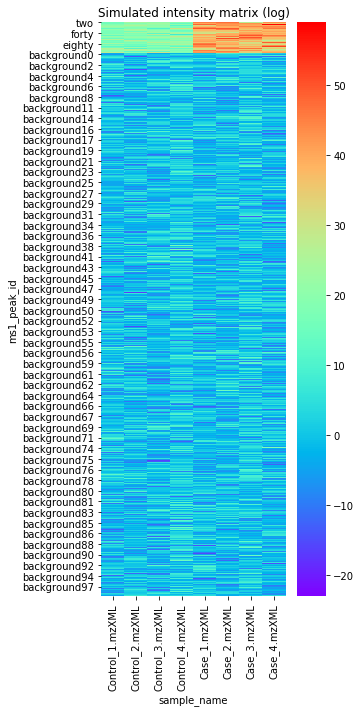

In [7]:
int_df, updated_pathway_names = construct_intensity_df(sample_fnames, pathway_names, random=False, background_pathways=bg_pw)
print(int_df.shape)
print(updated_pathway_names)

out_file = os.path.join(base_dir, 'simulated_intensity.eps')
plot_intensity_matrix(int_df, out_file=out_file)

Convert simulated data above to a PALS DataSource object and run pathway analysis

In [8]:
ds = convert_to_data_source(int_df, updated_pathway_names, case_fnames, control_fnames, prob_missing_peaks, min_replace)

2020-03-06 14:10:27.959 | DEBUG    | pals.noise:convert_to_data_source:111 - Dataset annotations = 2966
2020-03-06 14:10:27.959 | DEBUG    | pals.noise:convert_to_data_source:115 - Sampled annotations = 2966 with prob_missing_peaks=0.20
2020-03-06 14:10:27.960 | DEBUG    | pals.feature_extraction:__init__:47 - Using user-provided database
2020-03-06 14:10:27.961 | DEBUG    | pals.feature_extraction:__init__:55 - Mapping pathway to unique ids
2020-03-06 14:10:27.963 | DEBUG    | pals.feature_extraction:__init__:69 - Creating dataset to pathway mapping
2020-03-06 14:10:28.162 | DEBUG    | pals.feature_extraction:__init__:97 - Computing unique id counts
2020-03-06 14:10:28.168 | DEBUG    | pals.feature_extraction:__init__:47 - Using user-provided database
2020-03-06 14:10:28.168 | DEBUG    | pals.feature_extraction:__init__:55 - Mapping pathway to unique ids
2020-03-06 14:10:28.170 | DEBUG    | pals.feature_extraction:__init__:69 - Creating dataset to pathway mapping
2020-03-06 14:10:28.3

In [9]:
pals = PALS(ds, plage_weight=plage_weight, hg_weight=hg_weight)
pals_df = pals.get_pathway_df()
pals_df.sort_values('pw_name')

2020-03-06 14:10:28.413 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:295 - Setting the zero intensity values in the dataframe
2020-03-06 14:10:28.430 | DEBUG    | pals.feature_extraction:standardize_intensity_df:276 - Scaling the data across the sample: zero mean and unit variance
2020-03-06 14:10:28.433 | DEBUG    | pals.PALS:get_plage_activity_df:79 - Mean values of the rows in the DF is [ 0.  0. -0. ... -0.  0. -0.]
2020-03-06 14:10:28.433 | DEBUG    | pals.PALS:get_plage_activity_df:80 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2020-03-06 14:10:28.665 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:91 - Calculating plage p-values with resampling
2020-03-06 14:10:28.666 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:98 - Comparison case/control
2020-03-06 14:10:28.666 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:106 - Resampling 0/1000
2020-03-06 14:10:28.785 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:106 - Resampling 100/1000
2020-03-

,pw_name,case/control p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,case/control comb_p
background0,background0,1.000000,33,25,75.76,0.799968,26.39,79.97,1.000000
background1,background1,0.680893,9,3,33.33,0.999691,7.20,80.00,0.680893
background10,background10,1.000000,19,15,78.95,0.672459,15.19,79.95,1.000000
background11,background11,1.000000,14,12,85.71,0.446657,11.20,80.00,1.000000
background12,background12,1.000000,23,19,82.61,0.499073,18.39,79.96,1.000000
...,...,...,...,...,...,...,...,...,...
four,four,0.096163,4,3,75.00,0.818889,3.20,80.00,0.096163
six,six,0.003852,6,4,66.67,0.900996,4.80,80.00,0.003852
ten,ten,0.004016,10,8,80.00,0.677086,8.00,80.00,0.004016
twenty,twenty,0.000288,20,18,90.00,0.204318,15.99,79.95,0.000288


In [10]:
ora = ORA(ds)
ora_df = ora.get_pathway_df(correct_multiple_tests=True)
ora_df.sort_values('pw_name')

2020-03-06 14:10:30.189 | DEBUG    | pals.ORA:get_pathway_df:34 - Calculating ORA
2020-03-06 14:10:30.190 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:295 - Setting the zero intensity values in the dataframe
2020-03-06 14:10:30.743 | DEBUG    | pals.ORA:get_pathway_df:97 - Correcting for multiple t-tests
2020-03-06 14:10:30.747 | DEBUG    | pals.feature_extraction:_calculate_coverage_df:316 - Calculating dataset formula coverage


,pw_name,case/control p-value,case/control comb_p,unq_pw_F,tot_ds_F,F_coverage
background0,background0,9.329973e-01,1.000000e+00,33,25,75.76
background1,background1,5.200477e-01,1.000000e+00,9,3,33.33
background10,background10,7.882683e-01,1.000000e+00,19,15,78.95
background11,background11,1.000000e+00,1.000000e+00,14,12,85.71
background12,background12,1.000000e+00,1.000000e+00,23,19,82.61
...,...,...,...,...,...,...
four,four,1.781890e-03,3.177703e-02,4,3,75.00
six,six,4.828513e-04,1.033302e-02,6,4,66.67
ten,ten,4.901765e-08,1.311222e-06,10,8,80.00
twenty,twenty,1.059541e-18,3.779029e-17,20,18,90.00


In [11]:
gsea = GSEA(ds, num_resamples=gsea_resamples, method=gsea_ranking_method)
gsea_df = gsea.get_pathway_df()
gsea_df.sort_values('pw_name')

2020-03-06 14:10:30.846 | DEBUG    | pals.GSEA:__init__:36 - GSEA initialised with num_resamples=1000 and ranking_method=signal_to_noise
2020-03-06 14:10:30.848 | DEBUG    | pals.GSEA:get_pathway_df:52 - Calculating GSEA
2020-03-06 14:10:30.849 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:295 - Setting the zero intensity values in the dataframe
2020-03-06 14:10:30.876 | DEBUG    | pals.GSEA:get_pathway_df:81 - Running comparison case=case control=control
2020-03-06 14:10:36.429 | DEBUG    | pals.feature_extraction:_calculate_coverage_df:316 - Calculating dataset formula coverage


,pw_name,case/control p-value,case/control comb_p,case/control ES_score,unq_pw_F,tot_ds_F,F_coverage
background0,background0,0.688525,0.904376,-0.173824,33,25,75.76
background1,background1,0.859649,0.935496,-0.383832,9,3,33.33
background10,background10,0.129032,0.711702,-0.434741,19,15,78.95
background11,background11,0.415385,0.945000,-0.310273,14,12,85.71
background12,background12,0.456140,0.858012,0.229297,23,19,82.61
...,...,...,...,...,...,...,...
four,four,0.000000,0.075176,0.910933,4,3,75.00
six,six,0.000000,0.074930,0.795608,6,4,66.67
ten,ten,0.000000,0.007370,0.785110,10,8,80.00
twenty,twenty,0.000000,0.082915,0.783772,20,18,90.00


Now take the synthetic data matrix above, add some noisy peaks (100%) and run pathway analysis methods again.

(3371, 8)


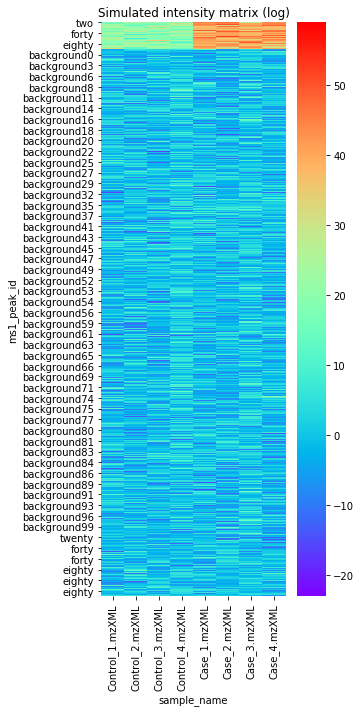

In [12]:
percent = 250
noise_mean = 0
noise_std = 5
int_df = add_random_peaks(sample_fnames, pathway_names, int_df, percent, noise_mean, noise_std)
print(int_df.shape)
plot_intensity_matrix(int_df)

In [13]:
ds = convert_to_data_source(int_df, updated_pathway_names, case_fnames, control_fnames, prob_missing_peaks, min_replace)

2020-03-06 14:10:37.691 | DEBUG    | pals.noise:convert_to_data_source:111 - Dataset annotations = 3371
2020-03-06 14:10:37.692 | DEBUG    | pals.noise:convert_to_data_source:115 - Sampled annotations = 3371 with prob_missing_peaks=0.20
2020-03-06 14:10:37.693 | DEBUG    | pals.feature_extraction:__init__:47 - Using user-provided database
2020-03-06 14:10:37.694 | DEBUG    | pals.feature_extraction:__init__:55 - Mapping pathway to unique ids
2020-03-06 14:10:37.696 | DEBUG    | pals.feature_extraction:__init__:69 - Creating dataset to pathway mapping
2020-03-06 14:10:37.908 | DEBUG    | pals.feature_extraction:__init__:97 - Computing unique id counts
2020-03-06 14:10:37.913 | DEBUG    | pals.feature_extraction:__init__:47 - Using user-provided database
2020-03-06 14:10:37.914 | DEBUG    | pals.feature_extraction:__init__:55 - Mapping pathway to unique ids
2020-03-06 14:10:37.916 | DEBUG    | pals.feature_extraction:__init__:69 - Creating dataset to pathway mapping
2020-03-06 14:10:38.0

In [14]:
pals = PALS(ds, plage_weight=plage_weight, hg_weight=hg_weight)
pals_df = pals.get_pathway_df()
pals_df.sort_values('pw_name')

2020-03-06 14:10:38.178 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:295 - Setting the zero intensity values in the dataframe
2020-03-06 14:10:38.192 | DEBUG    | pals.feature_extraction:standardize_intensity_df:276 - Scaling the data across the sample: zero mean and unit variance
2020-03-06 14:10:38.195 | DEBUG    | pals.PALS:get_plage_activity_df:79 - Mean values of the rows in the DF is [0. 0. 0. ... 0. 0. 0.]
2020-03-06 14:10:38.196 | DEBUG    | pals.PALS:get_plage_activity_df:80 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2020-03-06 14:10:38.419 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:91 - Calculating plage p-values with resampling
2020-03-06 14:10:38.419 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:98 - Comparison case/control
2020-03-06 14:10:38.420 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:106 - Resampling 0/1000
2020-03-06 14:10:38.525 | DEBUG    | pals.PALS:set_up_resample_plage_p_df:106 - Resampling 100/1000
2020-03-06 14:

,pw_name,case/control p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,case/control comb_p
background0,background0,0.997064,33,27,81.82,0.498694,26.39,79.97,0.997064
background1,background1,1.000000,9,7,77.78,0.737727,7.20,80.00,1.000000
background10,background10,1.000000,19,17,89.47,0.235335,15.20,80.00,1.000000
background11,background11,1.000000,14,11,78.57,0.697577,11.20,80.00,1.000000
background12,background12,1.000000,23,16,69.57,0.928758,18.39,79.96,1.000000
...,...,...,...,...,...,...,...,...,...
four,four,0.358208,14,10,71.43,0.870097,11.20,80.00,0.358208
six,six,0.123274,21,14,66.67,0.957187,16.80,80.00,0.123274
ten,ten,0.008825,35,26,74.29,0.854594,27.99,79.97,0.008825
twenty,twenty,0.004531,70,57,81.43,0.449430,55.98,79.97,0.004531


In [15]:
ora = ORA(ds)
ora_df = ora.get_pathway_df(correct_multiple_tests=True)
ora_df.sort_values('pw_name')

2020-03-06 14:10:39.752 | DEBUG    | pals.ORA:get_pathway_df:34 - Calculating ORA
2020-03-06 14:10:39.753 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:295 - Setting the zero intensity values in the dataframe
2020-03-06 14:10:40.289 | DEBUG    | pals.ORA:get_pathway_df:97 - Correcting for multiple t-tests
2020-03-06 14:10:40.292 | DEBUG    | pals.feature_extraction:_calculate_coverage_df:316 - Calculating dataset formula coverage


,pw_name,case/control p-value,case/control comb_p,unq_pw_F,tot_ds_F,F_coverage
background0,background0,9.172367e-01,1.000000,33,27,81.82
background1,background1,1.000000e+00,1.000000,9,7,77.78
background10,background10,1.000000e+00,1.000000,19,17,89.47
background11,background11,1.000000e+00,1.000000,14,11,78.57
background12,background12,8.234227e-01,1.000000,23,16,69.57
...,...,...,...,...,...,...
four,four,1.502476e-02,0.321530,14,10,71.43
six,six,6.038177e-02,0.862078,21,14,66.67
ten,ten,6.254092e-04,0.016730,35,26,74.29
twenty,twenty,4.429493e-08,0.000002,70,57,81.43


In [16]:
gsea = GSEA(ds, num_resamples=gsea_resamples, method=gsea_ranking_method)
gsea_df = gsea.get_pathway_df()
gsea_df.sort_values('pw_name')

2020-03-06 14:10:40.383 | DEBUG    | pals.GSEA:__init__:36 - GSEA initialised with num_resamples=1000 and ranking_method=signal_to_noise
2020-03-06 14:10:40.385 | DEBUG    | pals.GSEA:get_pathway_df:52 - Calculating GSEA
2020-03-06 14:10:40.385 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:295 - Setting the zero intensity values in the dataframe
2020-03-06 14:10:40.407 | DEBUG    | pals.GSEA:get_pathway_df:81 - Running comparison case=case control=control
2020-03-06 14:10:45.975 | DEBUG    | pals.feature_extraction:_calculate_coverage_df:316 - Calculating dataset formula coverage


,pw_name,case/control p-value,case/control comb_p,case/control ES_score,unq_pw_F,tot_ds_F,F_coverage
background0,background0,0.509804,1.000000,-0.197229,33,27,81.82
background1,background1,0.750000,1.000000,-0.377127,9,7,77.78
background10,background10,0.423077,1.000000,-0.305413,19,17,89.47
background11,background11,0.884615,0.903426,-0.223899,14,11,78.57
background12,background12,0.520833,0.780532,0.232023,23,16,69.57
...,...,...,...,...,...,...,...
four,four,0.333333,0.861345,0.297808,14,10,71.43
six,six,0.293103,0.907344,0.352617,21,14,66.67
ten,ten,0.035714,0.296273,0.406010,35,26,74.29
twenty,twenty,0.033898,0.062373,0.437358,70,57,81.43


### Experiments

### Experiment 1: adding noise

In [17]:
prob_missing_peaks = 0.20
noise_std = 5
reqd_scenarios = [
    { 'noise_std': noise_std, 'percent': 0, 'prob_missing_peaks': prob_missing_peaks, },
    { 'noise_std': noise_std, 'percent': 25, 'prob_missing_peaks': prob_missing_peaks, },
    { 'noise_std': noise_std, 'percent': 50, 'prob_missing_peaks': prob_missing_peaks, },
    { 'noise_std': noise_std, 'percent': 100, 'prob_missing_peaks': prob_missing_peaks, },        
    { 'noise_std': noise_std, 'percent': 250, 'prob_missing_peaks': prob_missing_peaks, },
    { 'noise_std': noise_std, 'percent': 500, 'prob_missing_peaks': prob_missing_peaks, },
    { 'noise_std': noise_std, 'percent': 1000, 'prob_missing_peaks': prob_missing_peaks, },
]

#### Run experiment

In this experiment, we add some % of noise to the data, and compares how the different methods perform.

In [ ]:
out_file = os.path.join(base_dir, 'experiment_1.p')

In [ ]:
pals_df, ora_df, gsea_df, exp_results = run_noise_experiment(bg_pw, case_fnames, control_fnames, pathway_names, num_iterations, plage_weight, hg_weight, gsea_resamples, gsea_ranking_method, 
                                                             reqd_scenarios, parallel=parallel)
combined_df = pd.concat([pals_df, ora_df, gsea_df])

In [ ]:
results = {
    'pals_df': pals_df,
    'ora_df': ora_df,
    'gsea_df': gsea_df,
    'combined_df': combined_df,
    'exp_results': exp_results
}
save_obj(results, out_file)

#### Load experiment results

In [18]:
out_file = os.path.join(base_dir, 'experiment_1.p')

In [19]:
results = load_obj(out_file)
pals_df = results['pals_df']
ora_df = results['ora_df']
gsea_df = results['gsea_df']
combined_df = results['combined_df']
exp_results = results['exp_results']

In [20]:
filtered_pals_df = pals_df[~pals_df.pathway.str.contains("background")].copy()
filtered_ora_df = ora_df[~ora_df.pathway.str.contains("background")].copy()
filtered_gsea_df = gsea_df[~gsea_df.pathway.str.contains("background")].copy()
filtered_combined_df = combined_df[~combined_df.pathway.str.contains("background")].copy()

In [21]:
background_pals_df = pals_df[pals_df.pathway.str.contains("background")].copy()
background_ora_df = ora_df[ora_df.pathway.str.contains("background")].copy()
background_gsea_df = gsea_df[gsea_df.pathway.str.contains("background")].copy()
background_combined_df = combined_df[combined_df.pathway.str.contains("background")].copy()

In [22]:
filtered_pals_df.groupby('percent').describe()

prob_missing                                             noise_std  \
               count mean           std  min  25%  50%  75%  max     count   
percent                                                                      
0.0           3485.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3485.0   
25.0          3497.0  0.2  2.775954e-17  0.2  0.2  0.2  0.2  0.2    3497.0   
50.0          3497.0  0.2  2.775954e-17  0.2  0.2  0.2  0.2  0.2    3497.0   
100.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
250.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
500.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
1000.0        3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   

              ...   p_value           comb_p_value                      \
        mean  ...       75%       max        count      mean       std   
percent       ...                                                        
0.0      5.0  ...  0.019328  0.998419       3485.0  0.021830  0.055395   
25.0     5.0  ...  0.026565  1.000000       3497.0  0.055893  0.166450   
50.0     5.0  ...  0.031660  1.000000       3497.0  0.057647  0.162980   
100.0    5.0  ...  0.046612  1.000000       3500.0  0.081299  0.202796   
250.0    5.0  ...  0.103342  1.000000       3500.0  0.141928  0.277188   
500.0    5.0  ...  0.309317  1.000000       3500.0  0.230424  0.345658   
1000.0   5.0  ...  0.784636  1.000000       3500.0  0.339835  0.402139   

                                                               
                  min       25%       50%       75%       max  
percent                                                        
0.0      1.086857e-06  0.001080  0.004903  0.019328  0.998419  
25.0     1.281992e-06  0.001094  0.005921  0.026565  1.000000  
50.0     4.780548e-06  0.001228  0.006845  0.031660  1.000000  
100.0    3.077241e-07  0.001251  0.008339  0.046612  1.000000  
250.0    1.907119e-06  0.001954  0.015563  0.103342  1.000000  
500.0    1.724956e-05  0.003547  0.035097  0.309317  1.000000  
1000.0   1.765562e-05  0.008666  0.101470  0.784636  1.000000  

[7 rows x 32 columns]

In [23]:
filtered_ora_df.groupby('percent').describe()

prob_missing                                             noise_std  \
               count mean           std  min  25%  50%  75%  max     count   
percent                                                                      
0.0           3485.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3485.0   
25.0          3497.0  0.2  2.775954e-17  0.2  0.2  0.2  0.2  0.2    3497.0   
50.0          3497.0  0.2  2.775954e-17  0.2  0.2  0.2  0.2  0.2    3497.0   
100.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
250.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
500.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
1000.0        3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   

              ...   p_value      comb_p_value                      \
        mean  ...       75%  max        count      mean       std   
percent       ...                                                   
0.0      5.0  ...  0.000575  1.0       3485.0  0.079174  0.235112   
25.0     5.0  ...  0.002474  1.0       3497.0  0.115445  0.269168   
50.0     5.0  ...  0.003716  1.0       3497.0  0.119627  0.270146   
100.0    5.0  ...  0.010183  1.0       3500.0  0.163057  0.302447   
250.0    5.0  ...  0.022599  1.0       3500.0  0.285852  0.405121   
500.0    5.0  ...  0.090300  1.0       3500.0  0.421758  0.448112   
1000.0   5.0  ...  0.195345  1.0       3500.0  0.600394  0.444992   

                                                              
                  min           25%       50%       75%  max  
percent                                                       
0.0      5.190540e-74  6.518624e-24  0.000002  0.011827  1.0  
25.0     3.286149e-62  2.928778e-20  0.000021  0.048575  1.0  
50.0     1.650519e-56  1.654024e-17  0.000115  0.074377  1.0  
100.0    1.490815e-45  7.910848e-14  0.000316  0.192864  1.0  
250.0    2.336436e-31  3.706163e-08  0.018353  0.449402  1.0  
500.0    9.797713e-20  1.286308e-04  0.157521  1.000000  1.0  
1000.0   3.240982e-13  3.828828e-02  0.978931  1.000000  1.0  

[7 rows x 32 columns]

In [24]:
filtered_gsea_df.groupby('percent').describe()

prob_missing                                             noise_std  \
               count mean           std  min  25%  50%  75%  max     count   
percent                                                                      
0.0           3485.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3485.0   
25.0          3497.0  0.2  2.775954e-17  0.2  0.2  0.2  0.2  0.2    3497.0   
50.0          3497.0  0.2  2.775954e-17  0.2  0.2  0.2  0.2  0.2    3497.0   
100.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
250.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
500.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
1000.0        3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   

              ...   p_value      comb_p_value                           \
        mean  ...       75%  max        count      mean       std  min   
percent       ...                                                        
0.0      5.0  ...  0.060000  1.0       3485.0  0.217807  0.294540  0.0   
25.0     5.0  ...  0.080000  1.0       3497.0  0.253907  0.319610  0.0   
50.0     5.0  ...  0.092593  1.0       3497.0  0.281551  0.331977  0.0   
100.0    5.0  ...  0.129630  1.0       3500.0  0.333172  0.355900  0.0   
250.0    5.0  ...  0.262511  1.0       3500.0  0.544480  0.369912  0.0   
500.0    5.0  ...  0.421053  1.0       3500.0  0.724932  0.319683  0.0   
1000.0   5.0  ...  0.577429  1.0       3500.0  0.855922  0.228620  0.0   

                                            
              25%       50%       75%  max  
percent                                     
0.0      0.015638  0.057837  0.324491  1.0  
25.0     0.016902  0.082432  0.414215  1.0  
50.0     0.019580  0.105931  0.488288  1.0  
100.0    0.027409  0.166952  0.621200  1.0  
250.0    0.169101  0.561006  0.946118  1.0  
500.0    0.489159  0.866621  1.000000  1.0  
1000.0   0.798331  0.988569  1.000000  1.0  

[7 rows x 32 columns]

Define seaborn styles. This will affect all plots from hereon.

In [25]:
sns.set(style="ticks")
style.use('seaborn-poster') #sets the size of the charts
sns.set_context('poster')  #Everything is larger

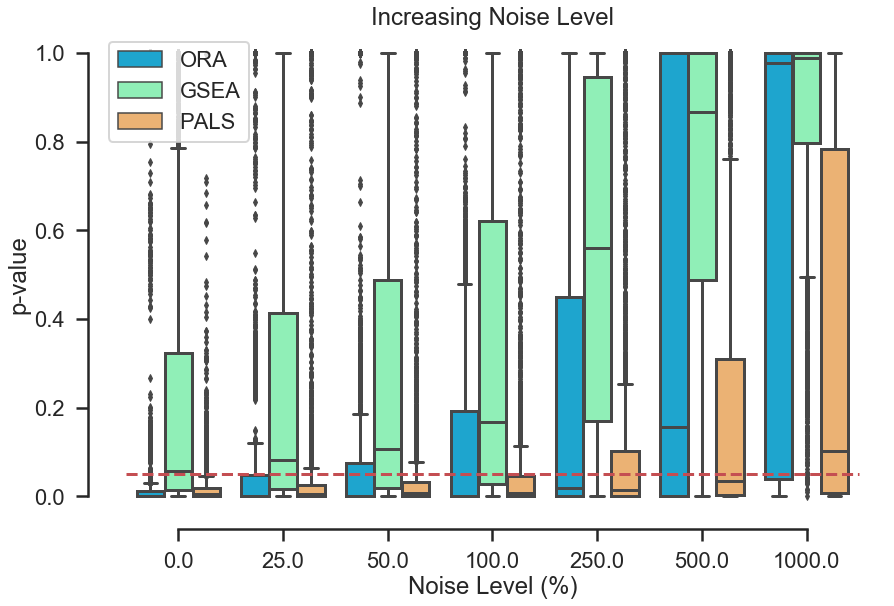

In [26]:
ax = sns.boxplot(x="percent", y="comb_p_value", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=filtered_combined_df, palette=("rainbow"))
ax.set(xlabel='Noise Level (%)', ylabel='p-value')
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.title('Increasing Noise Level')
plt.legend(loc='upper left')
plt.tight_layout()
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'adding_noise.eps')
plt.savefig(out_file, dpi=300)

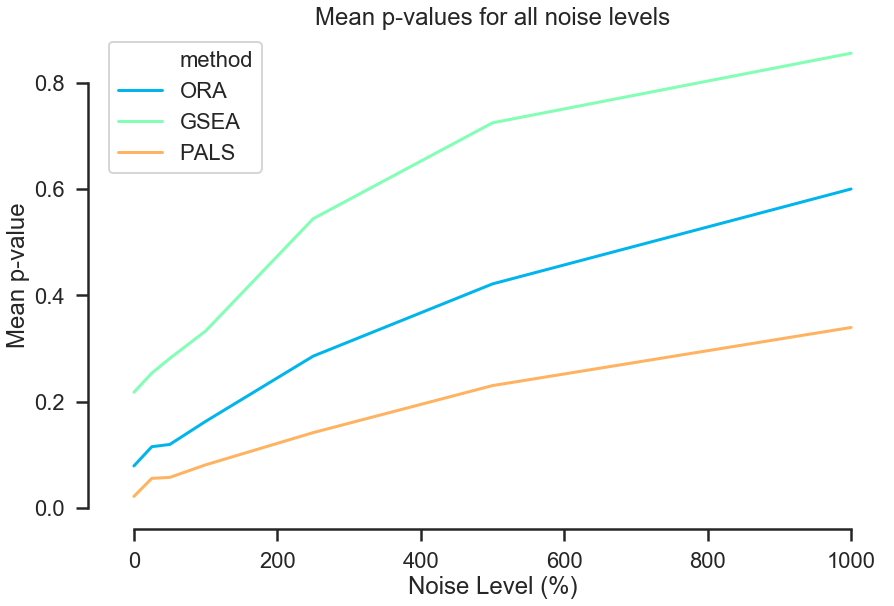

In [27]:
pals_pvalue_mean = pd.DataFrame(filtered_pals_df.groupby('percent').describe()['comb_p_value']['mean'])
ora_pvalue_mean = pd.DataFrame(filtered_ora_df.groupby('percent').describe()['comb_p_value']['mean'])
gsea_pvalue_mean = pd.DataFrame(filtered_gsea_df.groupby('percent').describe()['comb_p_value']['mean'])

pals_pvalue_mean['method'] = 'PALS'
ora_pvalue_mean['method'] = 'ORA'
gsea_pvalue_mean['method'] = 'GSEA'
combined_df = pd.concat([pals_pvalue_mean, ora_pvalue_mean, gsea_pvalue_mean])

ax = sns.lineplot(data=combined_df.reset_index(), x='percent', y='mean', hue='method', hue_order=['ORA', 'GSEA', 'PALS'], palette='rainbow')
ax.set(xlabel='Noise Level (%)', ylabel='Mean p-value')
plt.title('Mean p-values for all noise levels')

plt.tight_layout()
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'mean_pvalues.eps')
plt.savefig(out_file, dpi=300)

#### Plot for individual pathways

Make lineplot

In [28]:
sns.set(style="whitegrid")
style.use('seaborn-poster') #sets the size of the charts
sns.set_context('poster')  #Everything is larger

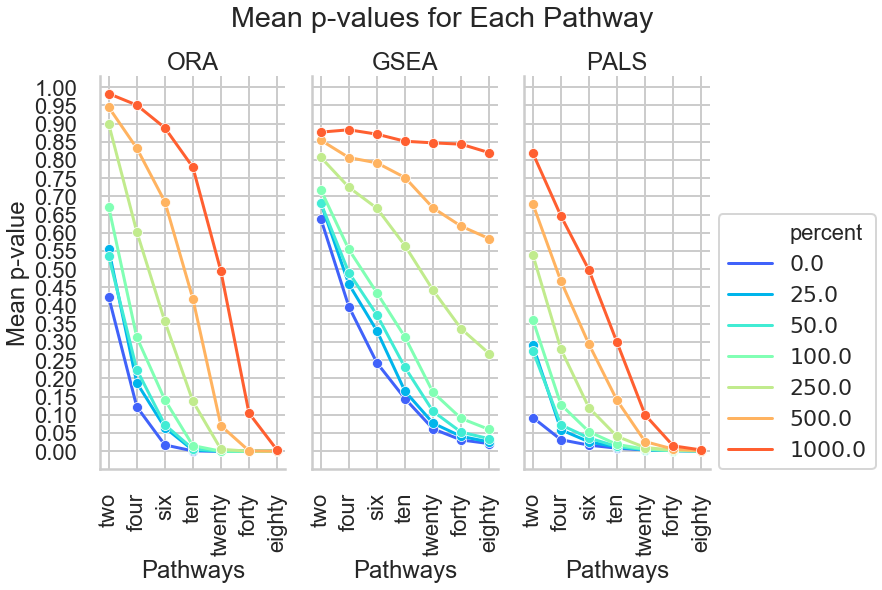

In [29]:
fig, axes = plt.subplots(1, 3, sharey=True)

df = filtered_ora_df
df = df.groupby(['pathway', 'percent']).describe()
df = pd.DataFrame(df['comb_p_value']['mean'])
df = pd.DataFrame(df.to_records())
df['pathway'] = pd.Categorical(df['pathway'], ['two', 'four', 'six', 'ten', 'twenty', 'forty', 'eighty'])
df = df.sort_values(['pathway', 'percent'])    
df['percent'] = ['$%s$' % x for x in df['percent']] # https://github.com/mwaskom/seaborn/issues/1653
ax = sns.lineplot(data=df, x='pathway', y='mean', hue='percent', palette=("rainbow"), marker='o', markersize=10, 
                  ax=axes[0], legend=False)
sns.despine()
ax.set(xlabel='Pathways', ylabel='Mean p-value')
ax.yaxis.set_ticks(np.arange(0, 1.05, 0.05))        
ax.set_title('ORA')

df = filtered_gsea_df
df = df.groupby(['pathway', 'percent']).describe()
df = pd.DataFrame(df['comb_p_value']['mean'])
df = pd.DataFrame(df.to_records())
df['pathway'] = pd.Categorical(df['pathway'], ['two', 'four', 'six', 'ten', 'twenty', 'forty', 'eighty'])
df = df.sort_values(['pathway', 'percent'])    
df['percent'] = ['$%s$' % x for x in df['percent']] # https://github.com/mwaskom/seaborn/issues/1653
ax = sns.lineplot(data=df, x='pathway', y='mean', hue='percent', palette=("rainbow"), marker='o', markersize=10, 
                  ax=axes[1], legend=False)
sns.despine()
ax.set(xlabel='Pathways', ylabel='Mean p-value')
ax.yaxis.set_ticks(np.arange(0, 1.05, 0.05))        
ax.set_title('GSEA')

df = filtered_pals_df
df = df.groupby(['pathway', 'percent']).describe()
df = pd.DataFrame(df['comb_p_value']['mean'])
df = pd.DataFrame(df.to_records())
df['pathway'] = pd.Categorical(df['pathway'], ['two', 'four', 'six', 'ten', 'twenty', 'forty', 'eighty'])
df = df.sort_values(['pathway', 'percent'])    
df['percent'] = ['$%s$' % x for x in df['percent']] # https://github.com/mwaskom/seaborn/issues/1653
ax = sns.lineplot(data=df, x='pathway', y='mean', hue='percent', palette=("rainbow"), marker='o', markersize=10, 
                  ax=axes[2], legend='brief')
sns.despine()
ax.set(xlabel='Pathways', ylabel='Mean p-value')
ax.yaxis.set_ticks(np.arange(0, 1.05, 0.05))        
ax.set_title('PALS')

ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
         # it will place the legend on the outer right-hand side of the last axes
    
for ax in fig.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90)
    
plt.suptitle('Mean p-values for Each Pathway')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
out_file = os.path.join(base_dir, 'mean_pvalues.eps')
plt.savefig(out_file, dpi=300)

Make barplots

In [30]:
filtered_pals_df['pathway'] = pd.Categorical(filtered_pals_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])
filtered_ora_df['pathway'] = pd.Categorical(filtered_ora_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])
filtered_gsea_df['pathway'] = pd.Categorical(filtered_gsea_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])

filtered_pals_df = filtered_pals_df.sort_values('pathway')
filtered_ora_df = filtered_ora_df.sort_values('pathway')
filtered_gsea_df = filtered_gsea_df.sort_values('pathway')

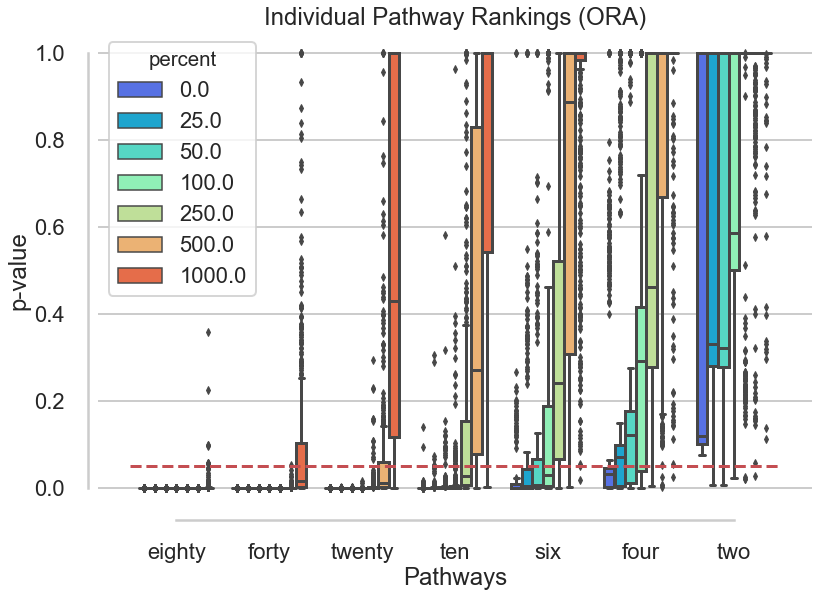

In [31]:
ax = sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=filtered_ora_df, palette=("rainbow"))
ax.set(xlabel='Pathways', ylabel='p-value')
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.title('Individual Pathway Rankings (ORA)')
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'pathway_ranking_ora.eps')
plt.savefig(out_file, dpi=300)

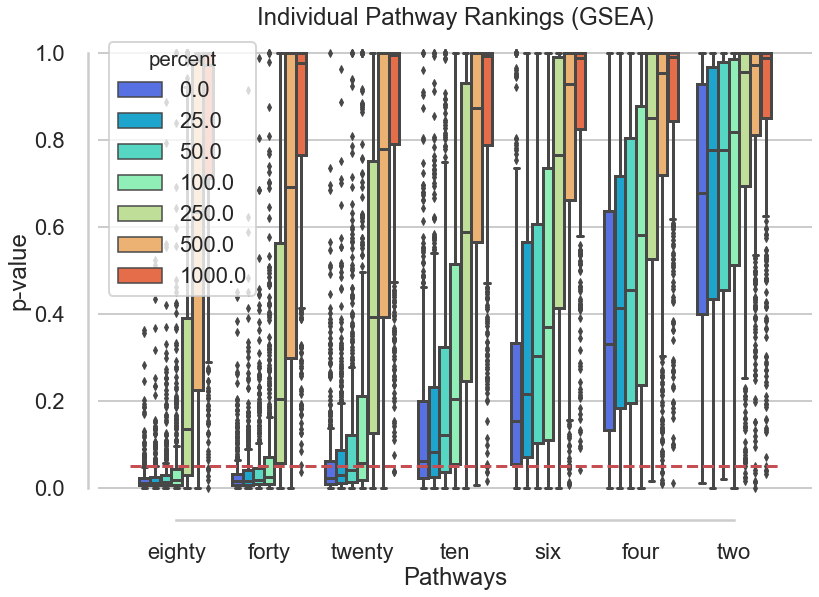

In [32]:
ax = sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=filtered_gsea_df, palette=("rainbow"))
ax.set(xlabel='Pathways', ylabel='p-value')
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.title('Individual Pathway Rankings (GSEA)')
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'pathway_ranking_gsea.eps')
plt.savefig(out_file, dpi=300)

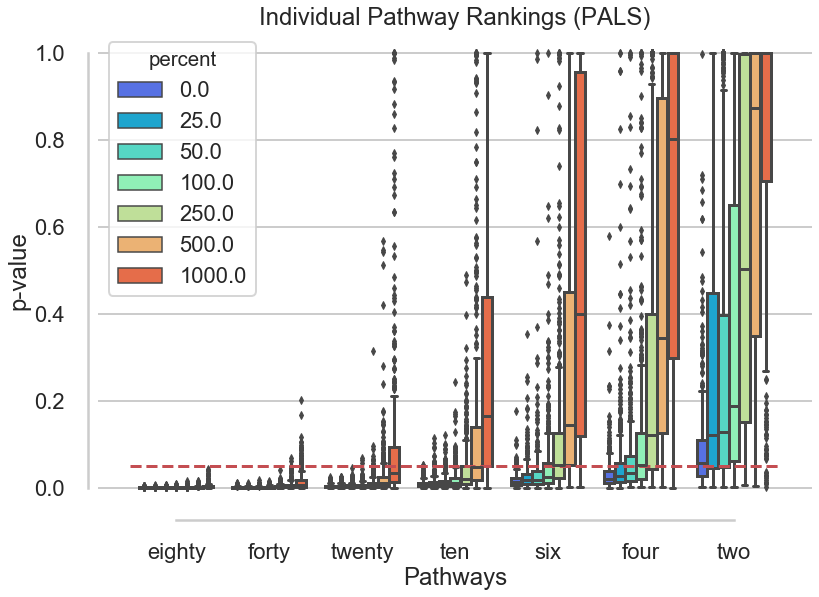

In [33]:
ax = sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=filtered_pals_df, palette=("rainbow"))
ax.set(xlabel='Pathways', ylabel='p-value')
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.title('Individual Pathway Rankings (PALS)')
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'pathway_ranking_pals.eps')
plt.savefig(out_file, dpi=300)

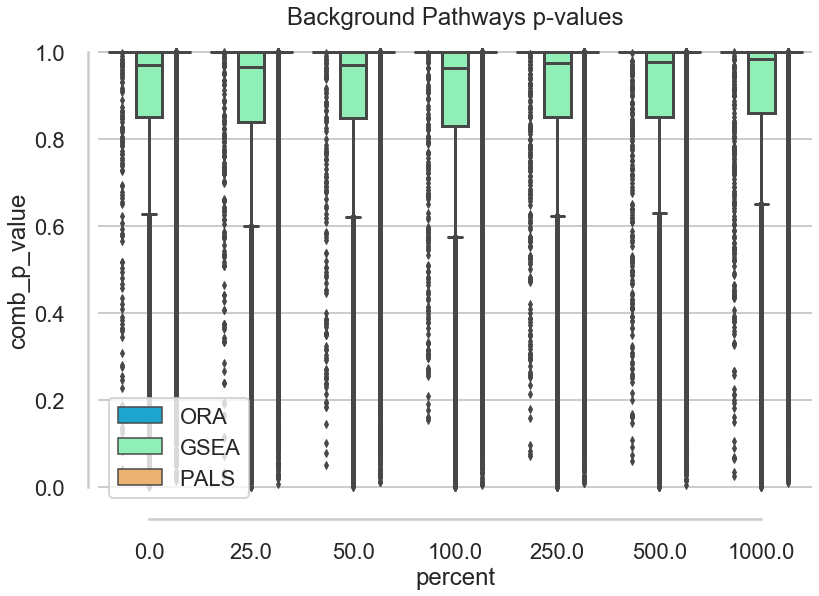

In [34]:
sns.boxplot(x='percent', y='comb_p_value', hue='method', data=background_combined_df, hue_order=['ORA', 'GSEA', 'PALS'], palette=("rainbow"))
plt.legend(loc='lower left')
plt.title('Background Pathways p-values')
sns.despine(offset=10, trim=True)

out_file = os.path.join(base_dir, 'background_pw_pvals.eps')
plt.savefig(out_file, dpi=300)

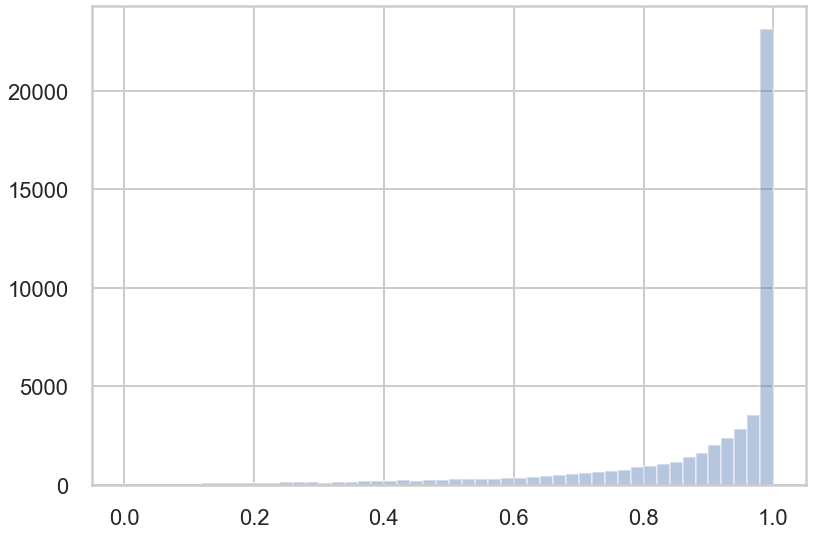

In [35]:
pvals = background_gsea_df[background_gsea_df['percent'] == 0].comb_p_value.values
sns.distplot(pvals, kde=False)

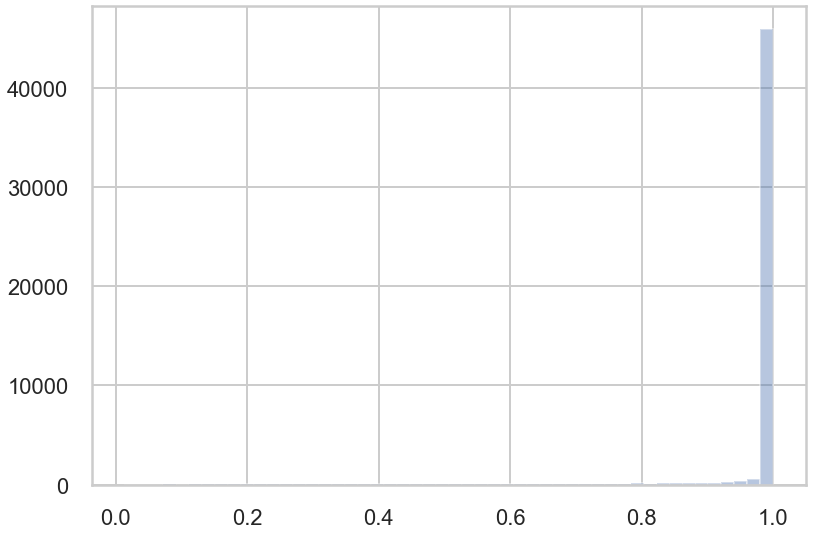

In [36]:
pvals = background_pals_df[background_pals_df['percent'] == 0].comb_p_value.values
sns.distplot(pvals, kde=False)

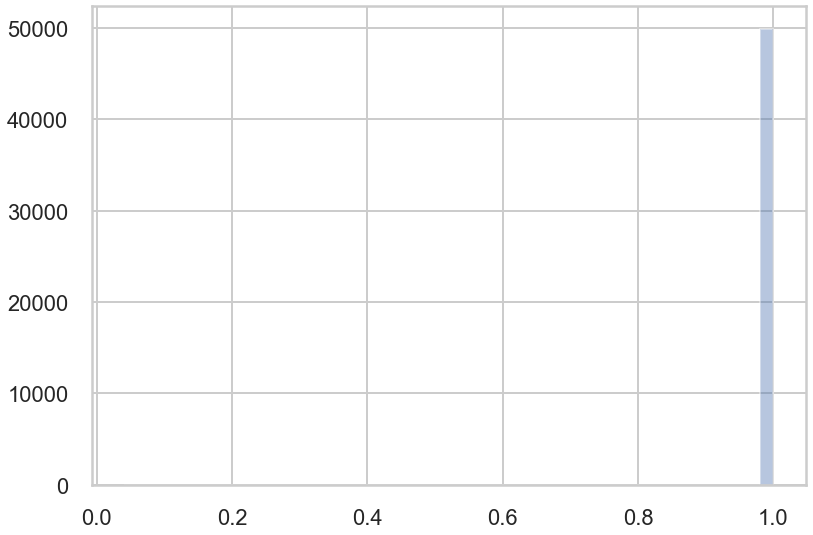

In [37]:
pvals = background_ora_df[background_ora_df['percent'] == 0].comb_p_value.values
sns.distplot(pvals, kde=False)

#### Better analysis where we consider TP, FP, FN

In [38]:
df = get_tp_fn_fn(reqd_scenarios, exp_results, true_answers)
out_file = os.path.join(base_dir, 'noise_performance.csv')
df.to_csv(out_file)
df

,method,noise_std,percent,prob_missing_peaks,TP,FP,FN,prec,rec,f1,TP_items,FP_items,FN_items
0,PALS,5,0,0.2,6,0,1,1.0,0.857143,0.923077,"{six, eighty, four, twenty, forty, ten}",{},{two}
1,PALS,5,0,0.2,7,0,0,1.0,1.000000,1.000000,"{two, six, four, eighty, twenty, forty, ten}",{},{}
2,PALS,5,0,0.2,5,0,2,1.0,0.714286,0.833333,"{six, eighty, twenty, forty, ten}",{},"{two, four}"
3,PALS,5,0,0.2,6,0,1,1.0,0.857143,0.923077,"{six, four, eighty, twenty, forty, ten}",{},{two}
4,PALS,5,0,0.2,6,0,1,1.0,0.857143,0.923077,"{six, four, eighty, twenty, forty, ten}",{},{two}
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,GSEA,5,1000,0.2,0,1,7,0.0,0.000000,0.000000,{},{background65},"{two, six, eighty, four, twenty, forty, ten}"
10496,GSEA,5,1000,0.2,0,0,7,0.0,0.000000,0.000000,{},{},"{two, twenty, forty, ten, six, eighty, four}"
10497,GSEA,5,1000,0.2,0,0,7,0.0,0.000000,0.000000,{},{},"{two, twenty, forty, ten, six, eighty, four}"
10498,GSEA,5,1000,0.2,0,0,7,0.0,0.000000,0.000000,{},{},"{two, twenty, forty, ten, six, eighty, four}"


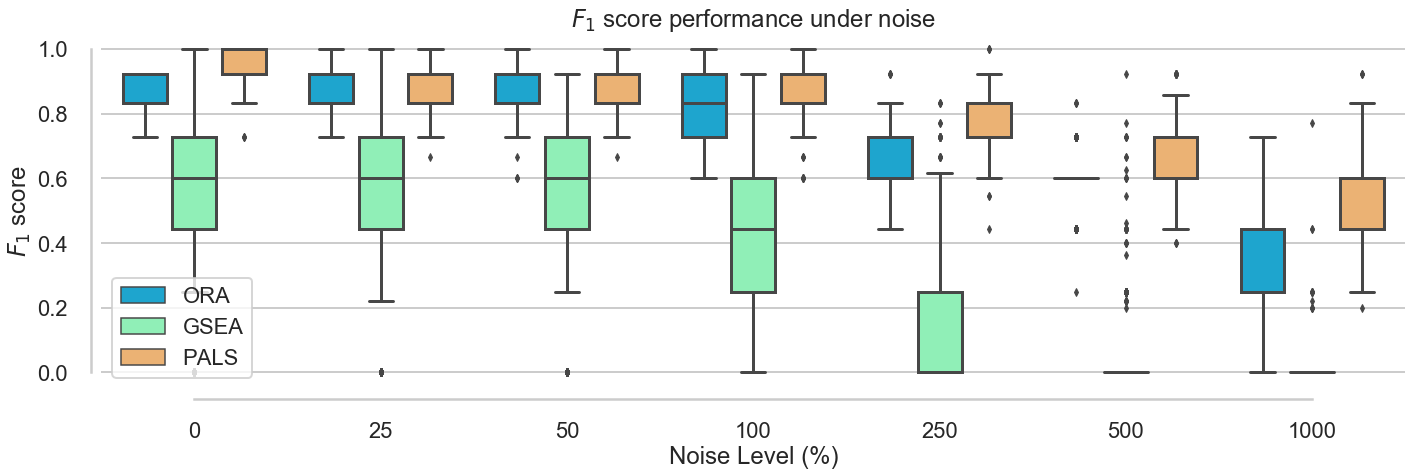

In [39]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="percent", y="f1", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Noise Level (%)', ylabel='$F_{1}$ score')
plt.title('$F_{1}$ score performance under noise')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.legend(loc='lower left')

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'f1_performance_with_noise.eps')
plt.savefig(out_file, dpi=300)

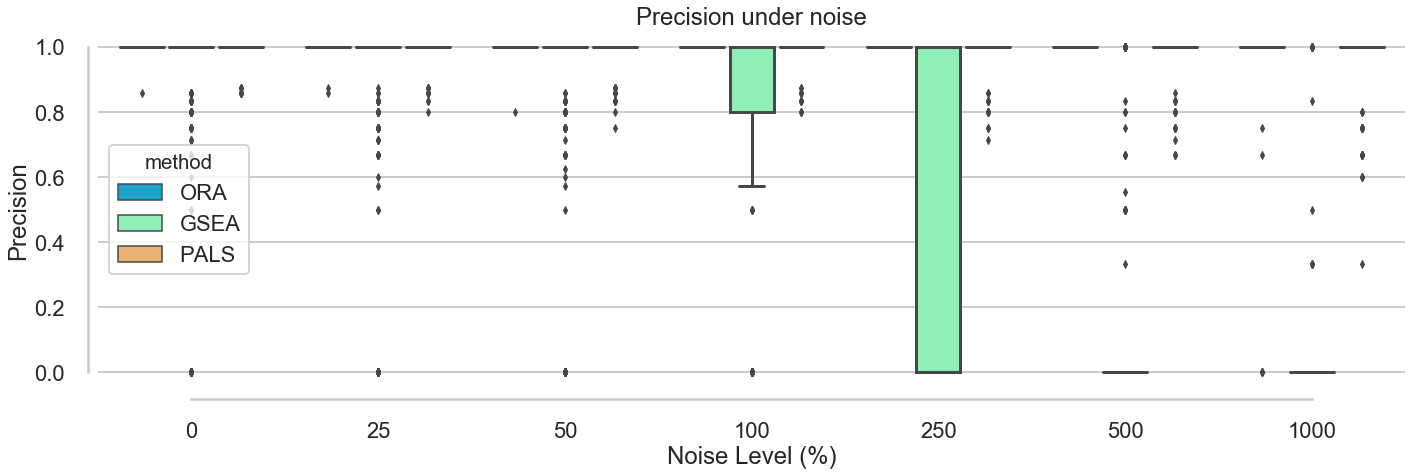

In [40]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="percent", y="prec", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Noise Level (%)', ylabel='Precision')
plt.title('Precision under noise')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'precision_with_noise.eps')
plt.savefig(out_file, dpi=300)

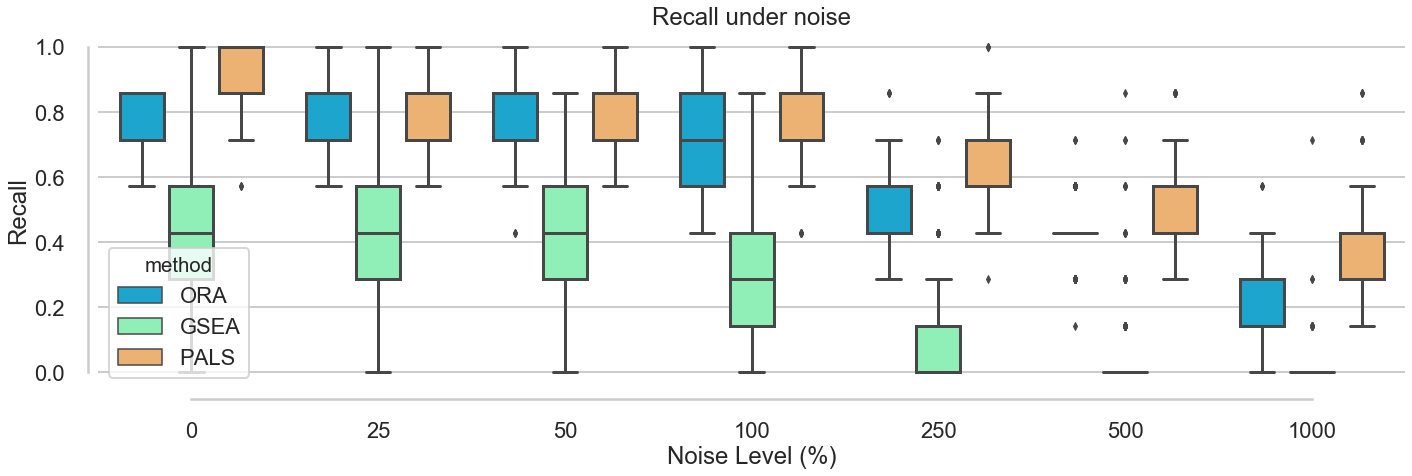

In [41]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="percent", y="rec", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Noise Level (%)', ylabel='Recall')
plt.title('Recall under noise')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'recall_with_noise.eps')
plt.savefig(out_file, dpi=300)

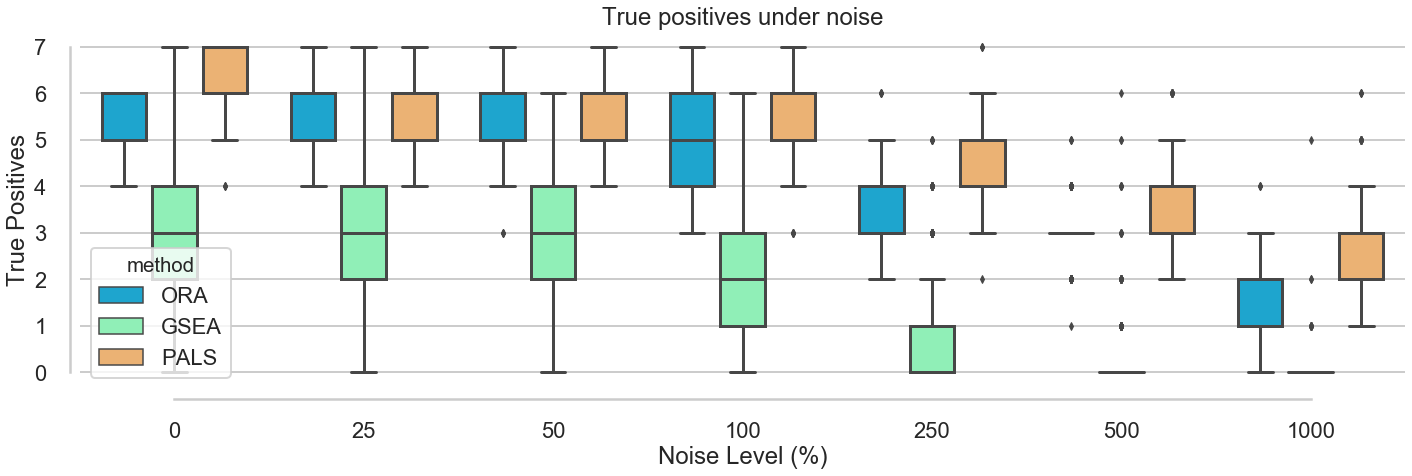

In [42]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="percent", y="TP", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Noise Level (%)', ylabel='True Positives')
plt.title('True positives under noise')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'TP_with_noise.eps')
plt.savefig(out_file, dpi=300)

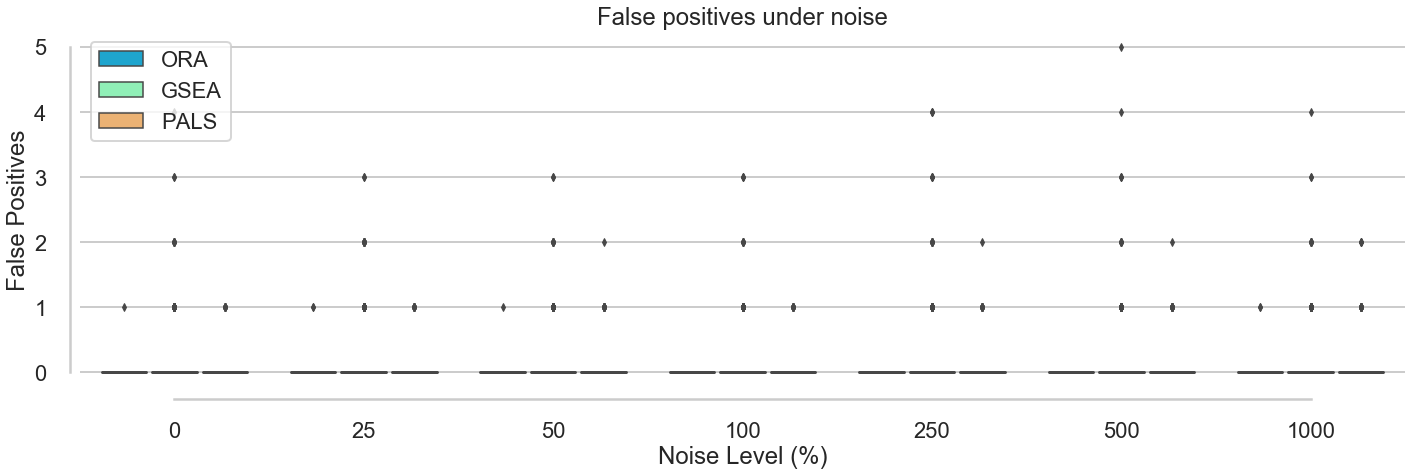

In [43]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="percent", y="FP", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Noise Level (%)', ylabel='False Positives')
plt.title('False positives under noise')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.legend(loc='upper left')

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'FP_with_noise.eps')
plt.savefig(out_file, dpi=300)

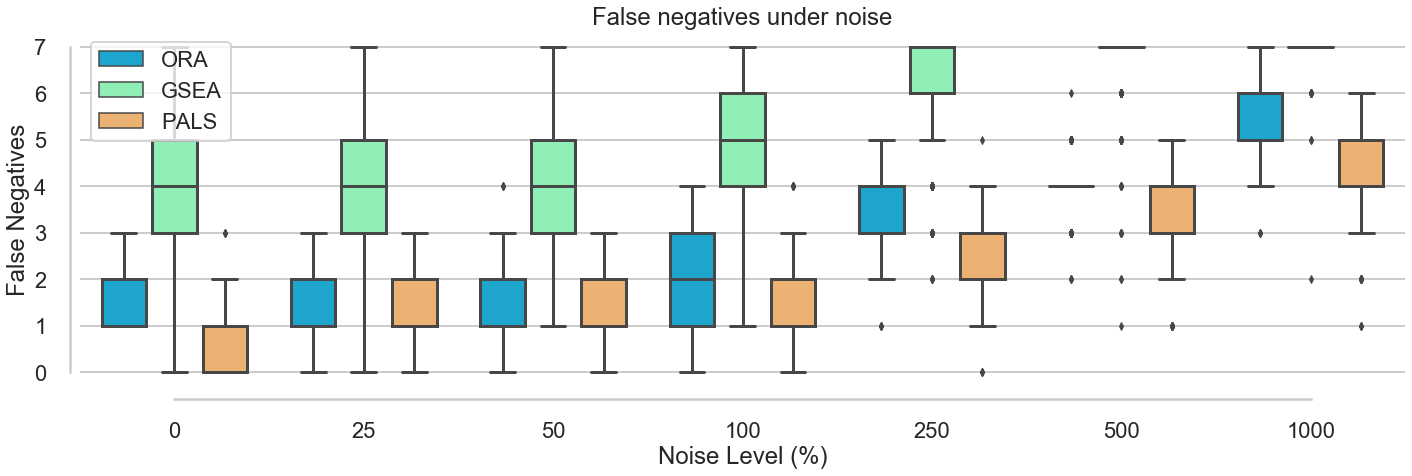

In [44]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="percent", y="FN", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Noise Level (%)', ylabel='False Negatives')
plt.title('False negatives under noise')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.legend(loc='upper left')

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'FN_with_noise.eps')
plt.savefig(out_file, dpi=300)

#### Compute PR curves and AUC

In [ ]:
auc_df = get_auc_for_noise(reqd_scenarios, exp_results, true_answers)

In [ ]:
auc_df

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="percent", y="auc", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=auc_df, palette=("rainbow"))
ax.set(xlabel='Noise Level (%)', ylabel='AUC')
plt.title('AUC performance under noise')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'auc_performance_with_noise.eps')
plt.savefig(out_file, dpi=300)

### Experiment 2: introducing missing peaks

In this experiment, we add a fixed (100%) noisy peaks, then increase the number of missing peaks in the data.

In [45]:
percent = 100
noise_std = 5
reqd_scenarios = [
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.2, },
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.4, },        
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.6, },
    { 'noise_std': noise_std, 'percent': percent, 'prob_missing_peaks': 0.8, },
]

#### Run experiment

In [ ]:
out_file = os.path.join(base_dir, 'experiment_2.p')

In [ ]:
pals_df, ora_df, gsea_df, exp_results = run_noise_experiment(bg_pw, case_fnames, control_fnames, pathway_names, num_iterations, plage_weight, hg_weight, gsea_resamples, gsea_ranking_method, 
                                                             reqd_scenarios, parallel=parallel)
combined_df = pd.concat([pals_df, ora_df, gsea_df])

In [ ]:
results = {
    'pals_df': pals_df,
    'ora_df': ora_df,
    'gsea_df': gsea_df,
    'combined_df': combined_df,
    'exp_results': exp_results
}
save_obj(results, out_file)

#### Load experiment results

In [46]:
out_file = os.path.join(base_dir, 'experiment_2.p')

In [47]:
results = load_obj(out_file)
pals_df = results['pals_df']
ora_df = results['ora_df']
gsea_df = results['gsea_df']
combined_df = results['combined_df']
exp_results = results['exp_results']

In [48]:
filtered_pals_df = pals_df[~pals_df.pathway.str.contains("background")].copy()
filtered_ora_df = ora_df[~ora_df.pathway.str.contains("background")].copy()
filtered_gsea_df = gsea_df[~gsea_df.pathway.str.contains("background")].copy()
filtered_combined_df = combined_df[~combined_df.pathway.str.contains("background")].copy()

In [49]:
filtered_pals_df.groupby('prob_missing').describe()

percent                                                noise_std  \
               count   mean  std    min    25%    50%    75%    max     count   
prob_missing                                                                    
0.2           3499.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3499.0   
0.4           3490.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3490.0   
0.6           3442.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3442.0   
0.8           3163.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3163.0   

                   ...   p_value      comb_p_value                      \
             mean  ...       75%  max        count      mean       std   
prob_missing       ...                                                   
0.2           5.0  ...  0.043635  1.0       3499.0  0.080166  0.203017   
0.4           5.0  ...  0.077024  1.0       3490.0  0.134234  0.277688   
0.6           5.0  ...  0.186010  1.0       3442.0  0.203677  0.346037   
0.8           5.0  ...  0.511143  1.0       3163.0  0.278165  0.389697   

                                                           
                   min       25%       50%       75%  max  
prob_missing                                               
0.2           0.000003  0.001392  0.008590  0.043635  1.0  
0.4           0.000002  0.001849  0.012129  0.077024  1.0  
0.6           0.000005  0.002963  0.020111  0.186010  1.0  
0.8           0.000003  0.005463  0.039676  0.511143  1.0  

[4 rows x 32 columns]

In [50]:
filtered_ora_df.groupby('prob_missing').describe()

percent                                                noise_std  \
               count   mean  std    min    25%    50%    75%    max     count   
prob_missing                                                                    
0.2           3499.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3499.0   
0.4           3490.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3490.0   
0.6           3442.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3442.0   
0.8           3163.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3163.0   

                   ...   p_value      comb_p_value                      \
             mean  ...       75%  max        count      mean       std   
prob_missing       ...                                                   
0.2           5.0  ...  0.009915  1.0       3499.0  0.162999  0.301933   
0.4           5.0  ...  0.020408  1.0       3490.0  0.249169  0.385637   
0.6           5.0  ...  0.081232  1.0       3442.0  0.371643  0.442635   
0.8           5.0  ...  0.160890  1.0       3163.0  0.498224  0.459585   

                                                                   
                       min           25%       50%       75%  max  
prob_missing                                                       
0.2           3.255253e-43  1.019225e-13  0.000451  0.194499  1.0  
0.4           2.244404e-40  2.009674e-09  0.006949  0.374431  1.0  
0.6           5.526966e-27  3.775396e-06  0.066694  1.000000  1.0  
0.8           1.267450e-16  3.349821e-03  0.359095  1.000000  1.0  

[4 rows x 32 columns]

In [51]:
filtered_gsea_df.groupby('prob_missing').describe()

percent                                                noise_std  \
               count   mean  std    min    25%    50%    75%    max     count   
prob_missing                                                                    
0.2           3499.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3499.0   
0.4           3490.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3490.0   
0.6           3442.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3442.0   
0.8           3163.0  100.0  0.0  100.0  100.0  100.0  100.0  100.0    3163.0   

                   ...   p_value      comb_p_value                           \
             mean  ...       75%  max        count      mean       std  min   
prob_missing       ...                                                        
0.2           5.0  ...  0.129630  1.0       3499.0  0.338231  0.353845  0.0   
0.4           5.0  ...  0.196648  1.0       3490.0  0.410401  0.369731  0.0   
0.6           5.0  ...  0.271368  1.0       3442.0  0.507406  0.376941  0.0   
0.8           5.0  ...  0.375000  1.0       3163.0  0.599804  0.365990  0.0   

                                                 
                   25%       50%       75%  max  
prob_missing                                     
0.2           0.027116  0.184515  0.634909  1.0  
0.4           0.051752  0.309606  0.774308  1.0  
0.6           0.109689  0.516172  0.903489  1.0  
0.8           0.234622  0.691841  0.964536  1.0  

[4 rows x 32 columns]

In [52]:
# style.use('seaborn-poster') #sets the size of the charts
# sns.set(style="whitegrid")
# style.use('ggplot')
# sns.set_context('poster')  #Everything is larger

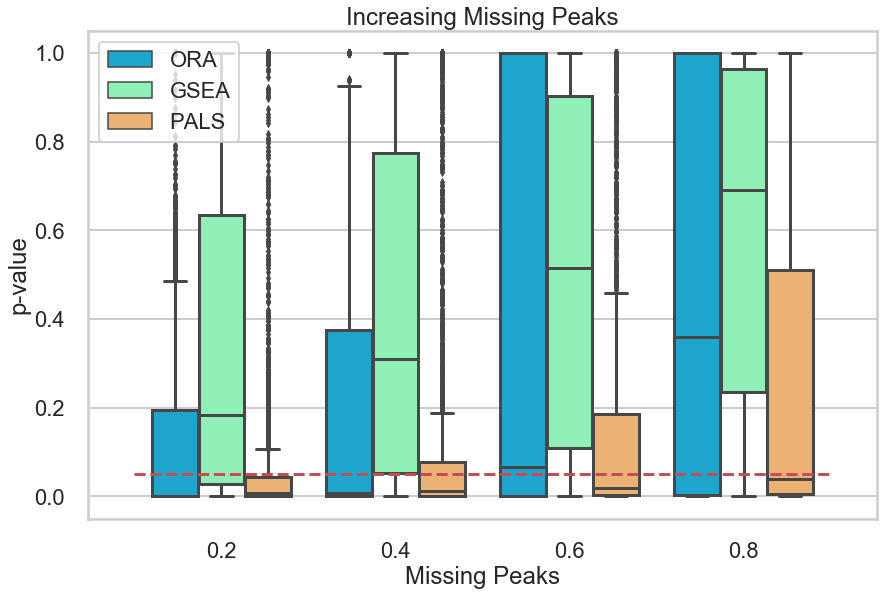

In [53]:
ax = sns.boxplot(x="prob_missing", y="comb_p_value", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=filtered_combined_df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks', ylabel='p-value')
plt.plot([-0.5, 3.5], [0.05, 0.05], 'r--')
plt.title('Increasing Missing Peaks')
plt.legend(loc='upper left')
plt.tight_layout()

out_file = os.path.join(base_dir, 'missing_peaks.eps')
plt.savefig(out_file, dpi=300)

#### Better analysis where we consider TP, FP, FN

In [54]:
df = get_tp_fn_fn(reqd_scenarios, exp_results, true_answers)
out_file = os.path.join(base_dir, 'missing_peaks_performance.csv')
df.to_csv(out_file)
df

,method,noise_std,percent,prob_missing_peaks,TP,FP,FN,prec,rec,f1,TP_items,FP_items,FN_items
0,PALS,5,100,0.2,5,0,2,1.000000,0.714286,0.833333,"{six, eighty, twenty, forty, ten}",{},"{two, four}"
1,PALS,5,100,0.2,5,0,2,1.000000,0.714286,0.833333,"{eighty, four, twenty, forty, ten}",{},"{two, six}"
2,PALS,5,100,0.2,6,0,1,1.000000,0.857143,0.923077,"{six, four, eighty, twenty, forty, ten}",{},{two}
3,PALS,5,100,0.2,7,0,0,1.000000,1.000000,1.000000,"{two, six, four, eighty, twenty, forty, ten}",{},{}
4,PALS,5,100,0.2,5,1,2,0.833333,0.714286,0.769231,"{eighty, four, twenty, forty, ten}",{background87},"{two, six}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,GSEA,5,100,0.8,3,0,4,1.000000,0.428571,0.600000,"{twenty, forty, eighty}",{},"{two, six, ten, four}"
5996,GSEA,5,100,0.8,0,0,7,0.000000,0.000000,0.000000,{},{},"{two, twenty, forty, ten, six, eighty, four}"
5997,GSEA,5,100,0.8,3,2,4,0.600000,0.428571,0.500000,"{twenty, forty, eighty}","{background98, background26}","{two, six, ten, four}"
5998,GSEA,5,100,0.8,0,0,7,0.000000,0.000000,0.000000,{},{},"{two, twenty, forty, ten, six, eighty, four}"


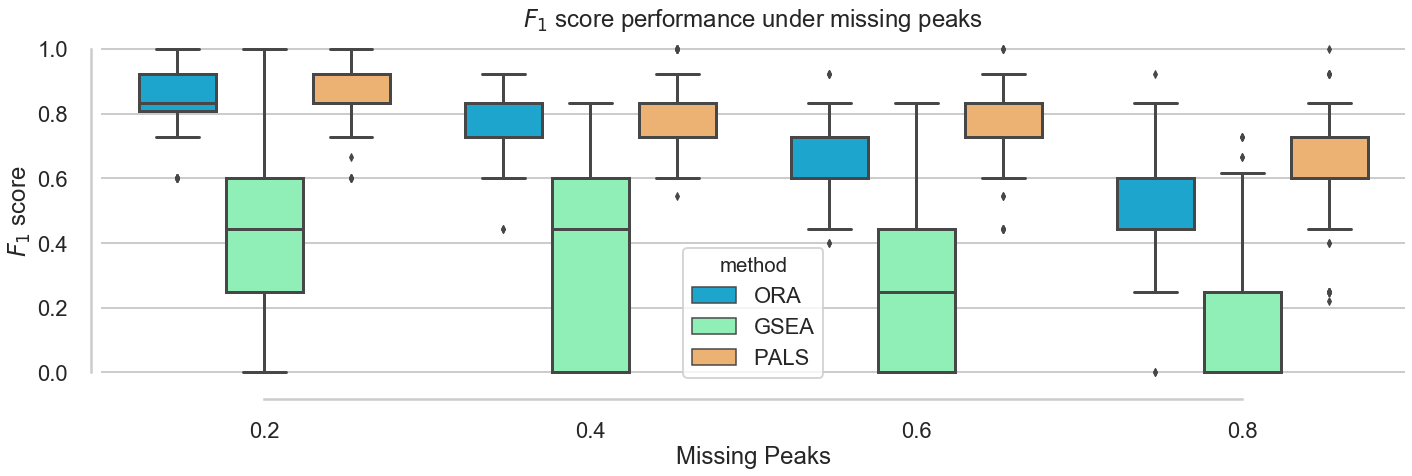

In [55]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="f1", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks', ylabel='$F_{1}$ score')
plt.title('$F_{1}$ score performance under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'f1_performance_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

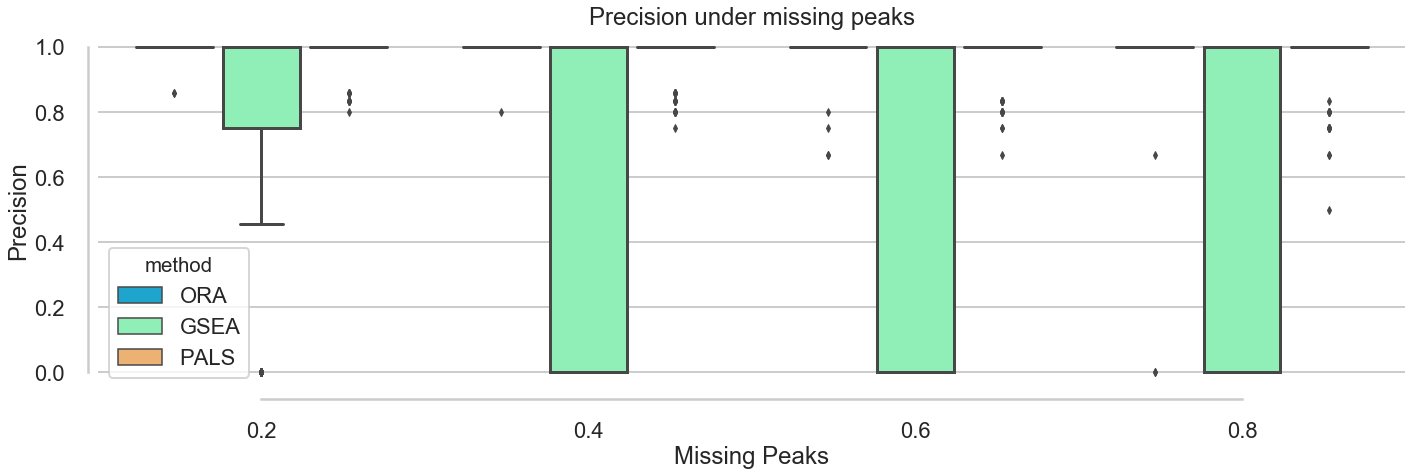

In [56]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="prec", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks', ylabel='Precision')
plt.title('Precision under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'precision_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

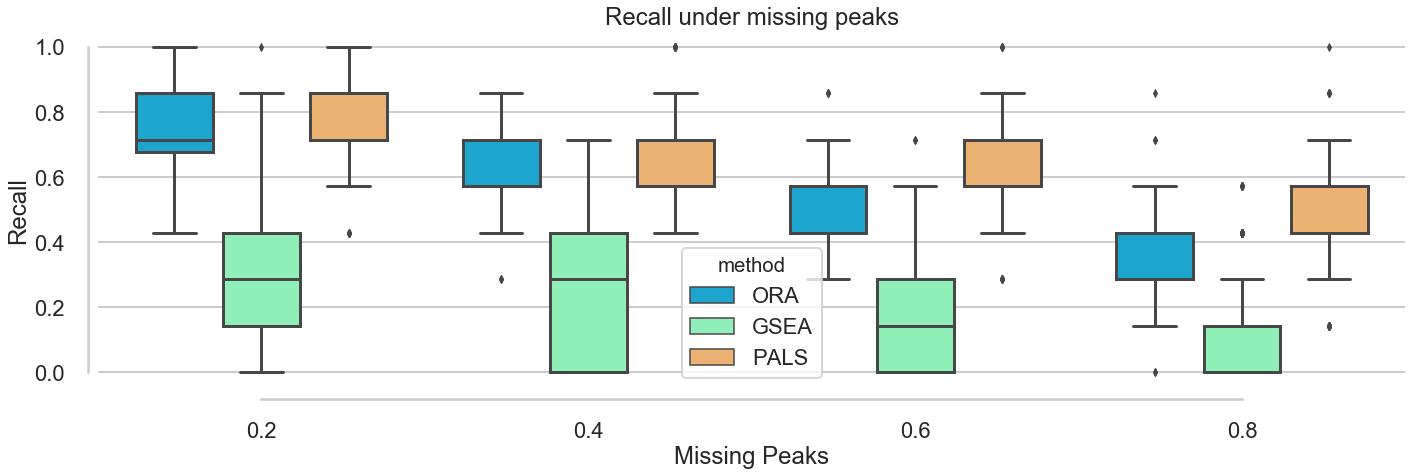

In [57]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="rec", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks', ylabel='Recall')
plt.title('Recall under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'recall_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

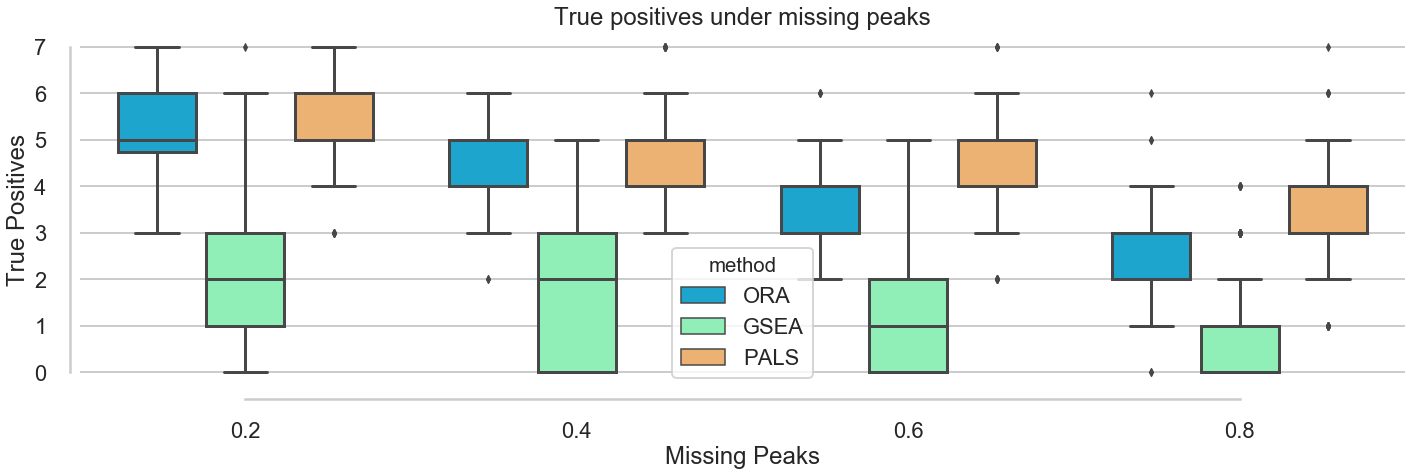

In [58]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="TP", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks', ylabel='True Positives')
plt.title('True positives under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'TP_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

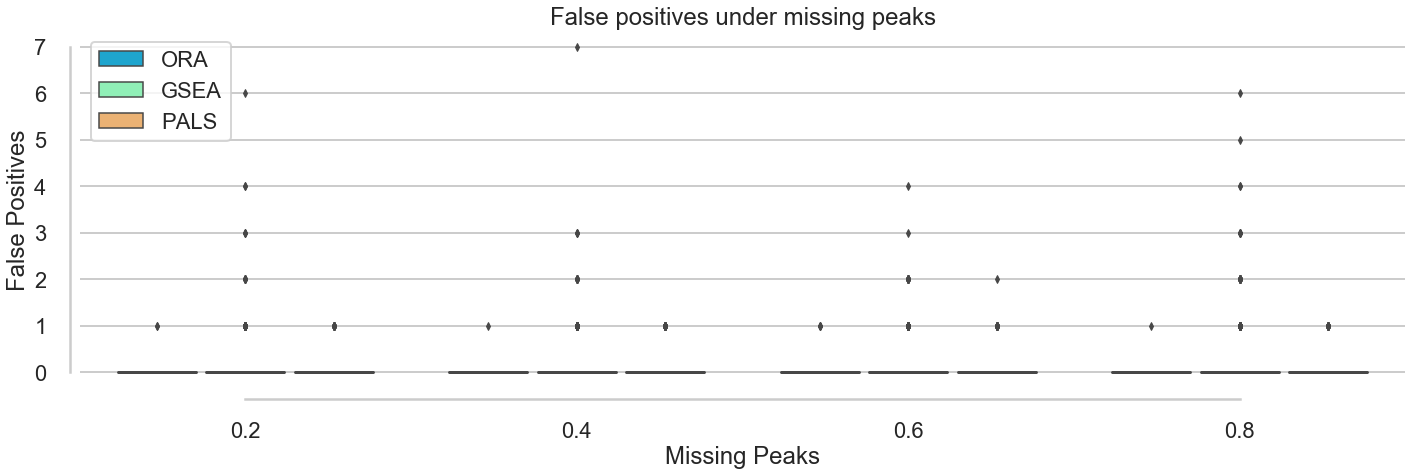

In [59]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="FP", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks', ylabel='False Positives')
plt.title('False positives under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.legend(loc='upper left')

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'FP_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

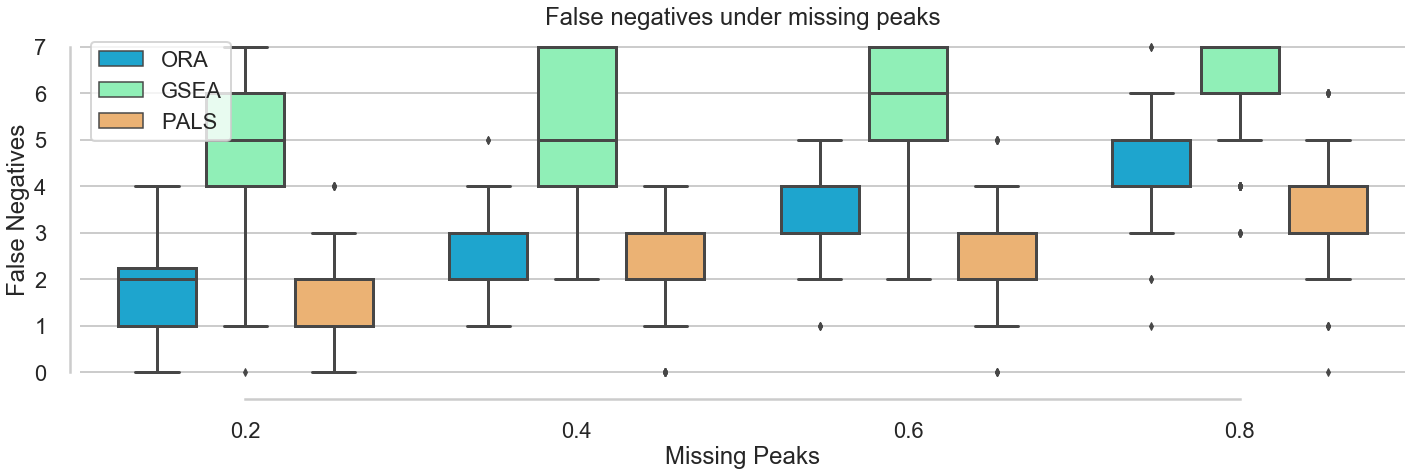

In [60]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="FN", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks', ylabel='False Negatives')
plt.title('False negatives under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.legend(loc='upper left')

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'FN_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

#### Compute PR curves and AUC

In [ ]:
auc_df = get_auc_for_noise(reqd_scenarios, exp_results, true_answers)

In [ ]:
auc_df

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = sns.boxplot(x="prob_missing_peaks", y="auc", hue='method', hue_order=['ORA', 'GSEA', 'PALS'], data=auc_df, palette=("rainbow"))
ax.set(xlabel='Missing Peaks', ylabel='AUC')
plt.title('AUC performance under missing peaks')
plt.tight_layout()
sns.despine(offset=10, trim=True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)

adjust_box_widths(fig, 0.9)
out_file = os.path.join(base_dir, 'auc_performance_with_missing_peaks.eps')
plt.savefig(out_file, dpi=300)

### Experiment 3: Nothing is changing, it's all random

In [61]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'divide by zero')
    warnings.filterwarnings('ignore', r'invalid value encountered')
    results = calc_av_p_scores(case_fnames, control_fnames, pathway_names, 1, random=True, plage_weight=plage_weight, hg_weight=hg_weight, gsea_resamples=gsea_resamples, gsea_ranking_method=gsea_ranking_method, 
                               background_pathways=bg_pw)
    pals_df = construct_single_box_df(results, 100, 0.2, 1, 'PALS')      
    ora_df = construct_single_box_df(results, 100, 0.2, 1, 'ORA')   
    gsea_df = construct_single_box_df(results, 100, 0.2, 1, 'GSEA')   

In [62]:
filtered_pals_df = pals_df[~pals_df.pathway.str.contains("background")].copy()
filtered_ora_df = ora_df[~ora_df.pathway.str.contains("background")].copy()
filtered_gsea_df = gsea_df[~gsea_df.pathway.str.contains("background")].copy()

In [63]:
filtered_ora_df

,pathway,percent,prob_missing,noise_std,p_value,comb_p_value,method
16,ten,100.0,0.2,1.0,1.000000,1.0,ORA
18,six,100.0,0.2,1.0,1.000000,1.0,ORA
20,eighty,100.0,0.2,1.0,1.000000,1.0,ORA
21,twenty,100.0,0.2,1.0,1.000000,1.0,ORA
28,four,100.0,0.2,1.0,1.000000,1.0,ORA
98,two,100.0,0.2,1.0,1.000000,1.0,ORA
101,forty,100.0,0.2,1.0,0.023458,1.0,ORA


In [64]:
filtered_pals_df

,pathway,percent,prob_missing,noise_std,p_value,comb_p_value,method
16,ten,100.0,0.2,1.0,1.00000,1.00000,PALS
18,six,100.0,0.2,1.0,1.00000,1.00000,PALS
20,eighty,100.0,0.2,1.0,1.00000,1.00000,PALS
21,twenty,100.0,0.2,1.0,1.00000,1.00000,PALS
28,four,100.0,0.2,1.0,1.00000,1.00000,PALS
98,two,100.0,0.2,1.0,1.00000,1.00000,PALS
101,forty,100.0,0.2,1.0,0.99642,0.99642,PALS


In [65]:
filtered_gsea_df

,pathway,percent,prob_missing,noise_std,p_value,comb_p_value,method
16,ten,100.0,0.2,1.0,0.736842,1.000000,GSEA
18,six,100.0,0.2,1.0,0.730769,1.000000,GSEA
20,eighty,100.0,0.2,1.0,0.851852,1.000000,GSEA
21,twenty,100.0,0.2,1.0,0.120690,1.000000,GSEA
28,four,100.0,0.2,1.0,0.781818,1.000000,GSEA
98,two,100.0,0.2,1.0,0.883333,0.966107,GSEA
101,forty,100.0,0.2,1.0,0.245614,1.000000,GSEA
